In [1]:
import re
import torch
import torch.nn as nn
import tiktoken



# Cloning repository and mounting drive

In [ ]:
!git clone https://github.com/BARUD77/Homework2.git
%cd Homework2


# Loading the cleaned and merged text file

In [ ]:
with open("cleaned_text.txt", "r") as f:
    cleaned_text = f.read()


# Tokenization with both regex and bpe tokenizers

### Regex tokenizer

In [ ]:
class SimpleTokenizer:
    def __init__(self, vocab):
        self.tokens2ids = {token:id for id,token in enumerate(vocab)}
        self.ids2tokens = {id:token for id,token in enumerate(vocab)}

    # encode function turns text into token IDs
    def encode(self, text):
    # Split the text using your regex
        text2tokens = re.split(r"([.,:;?_!\"'()\[\]—\-\s])", text)
        text2tokens = [item.strip() for item in text2tokens if item.strip()]

        # --- FIX START ---
        # Ensure <|unk|> is in vocab, or add it dynamically
        if "<|unk|>" not in self.tokens2ids:
            self.tokens2ids["<|unk|>"] = len(self.tokens2ids)
            self.ids2tokens[self.tokens2ids["<|unk|>"]] = "<|unk|>"
        unk_id = self.tokens2ids["<|unk|>"]
        # --- FIX END ---

        # Replace out-of-vocab tokens
        ids = [self.tokens2ids.get(tok, unk_id) for tok in text2tokens]
        return ids


    # decode function turns token IDs back into text
    def decode(self, ids):
        text = " ".join([self.ids2tokens[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [ ]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', cleaned_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])
print('Total Number of Tokens in "cleaned_2.txt" are ', len(preprocessed))

# Building the vocabulary
vocab = sorted(set(preprocessed))
vocab_size = len(vocab)

print("Vocabulary size:",vocab_size)
print(vocab[:20])

['Language', 'Models', 'are', 'Few-Shot', 'Learners', 'Tom', 'B', '.', 'Brown\x03Benjamin', 'Mann\x03Nick', 'Ryder\x03Melanie', 'Subbiah\x03', 'Jared', 'KaplanyPrafulla', 'Dhariwal', 'Arvind', 'Neelakantan', 'Pranav', 'Shyam', 'Girish', 'Sastry', 'Amanda', 'Askell', 'Sandhini', 'Agarwal', 'Ariel', 'Herbert-Voss', 'Gretchen', 'Krueger', 'Tom']
Total Number of Tokens in "cleaned_2.txt" are  555770
Vocabulary size: 33938
['\x00', '\x001', '\x0013%', '\x002', '\x00erce-looking', '\x00roEht', '\x01', '\x01Distributed', '\x01Natural', '\x01xV', '\x0210\x005', '\x023\x02m\x02t', '\x02PUE', '\x02smaller', '\x03\x06d', '\x03Davinci', '\x03Equal', '\x03l', '\x03t\x00l', '\x06']


In [ ]:
regextokenizer = SimpleTokenizer(vocab)

regex_token_integers = regextokenizer.encode(cleaned_text)
print(regex_token_integers[:100])
print(regextokenizer.decode(regex_token_integers[:100]))

[10689, 11825, 18428, 33938, 305, 33938, 10764, 15618, 5968, 441, 6418, 11376, 14068, 15018, 10018, 10270, 7650, 5826, 12179, 13087, 14656, 8912, 14289, 5639, 5852, 14264, 5495, 5796, 33938, 305, 33938, 9028, 10470, 15618, 9317, 13913, 6837, 5461, 13654, 7391, 11090, 441, 16962, 10042, 16563, 6934, 16495, 6886, 9343, 11416, 6807, 8064, 14672, 11449, 10913, 14387, 9015, 6187, 6828, 9975, 6913, 6886, 6196, 14249, 11514, 5562, 13619, 9595, 15090, 7400, 5657, 12486, 5398, 13747, 31809, 23154, 20855, 29683, 22771, 26146, 24963, 12038, 30001, 18131, 18894, 19211, 27097, 305, 30628, 26146, 17597, 24472, 20381, 26060, 30128, 22532, 19211, 33938, 305, 30761]
Language Models are <|unk|> - <|unk|> Learners Tom B. BrownBenjamin MannNick RyderMelanie Subbiah Jared KaplanyPrafulla Dhariwal Arvind Neelakantan Pranav Shyam Girish Sastry Amanda Askell Sandhini Agarwal Ariel <|unk|> - <|unk|> Gretchen Krueger Tom Henighan Rewon Child Aditya Ramesh Daniel M. Ziegler Jeffrey Wu Clemens Winter Christop

# Preparing the dataloader

In [ ]:
from model import GPTModel

gpt2=False
vocab_size = vocab_size
tokenizer = regextokenizer

GPT_CONFIG = {
"vocab_size": vocab_size, # Vocabulary size
"context_length": 256, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

model = GPTModel(GPT_CONFIG)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model (Millions): {total_params/1_000_000}")
print("-"*100)

Total number of parameters in the model (Millions): 137.353728
----------------------------------------------------------------------------------------------------


In [ ]:
from dataset import create_dataloader_v1
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(cleaned_text))
train_data = cleaned_text[:split_idx]
val_data = cleaned_text[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    gpt2,
    tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    gpt2,
    tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
total_train_characters = len(train_data)
total_train_tokens = len(tokenizer.encode(train_data))

print("Train Characters :", total_train_characters)
print("Train Tokens :", total_train_tokens)

print("="*100)

total_val_characters = len(val_data)
total_val_tokens = len(tokenizer.encode(val_data))

print("Validation Characters:", total_val_characters)
print("Validation Tokens:", total_val_tokens)

print("="*100)
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    break
print("="*100)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
    break

Train Characters : 2512230
Train Tokens : 538959
Validation Characters: 279137
Validation Tokens: 61251
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


# Pretraining

In [ ]:
from train import train_model_simple
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)

# estimate a token budget: ~5 epochs worth
B, T = next(iter(train_loader))[0].shape  # (B, T)
tokens_per_epoch = len(train_loader) * B * T
target_tokens = 30 * tokens_per_epoch

train_losses, val_losses, tokens_seen = train_model_simple(
    model, gpt2, train_loader, val_loader, optimizer, device,
    num_epochs=30,                 # large cap; early stopping will stop earlier
    eval_freq=200,                  # evaluate every N steps (tune to your speed)
    eval_iter=5,
    start_context="Finally, given the broad spectrum of capabilities displayed by GPT-3",
    tokenizer=tokenizer,
    # early stopping knobs
    early_stop=True, patience=5, min_delta=1e-3,
    save_path="checkpoints/regex/best.pt",
    use_plateau_lr=True, lr_factor=0.5, lr_patience=2, min_lr=1e-5,
    max_tokens_seen=target_tokens
)


c:\Users\user\miniconda3\envs\cuda_test\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
print("GPU name:", torch.cuda.get_device_name(device))
device

GPU name: NVIDIA GeForce RTX 4090


'cuda'

# Plotting training and validation losses

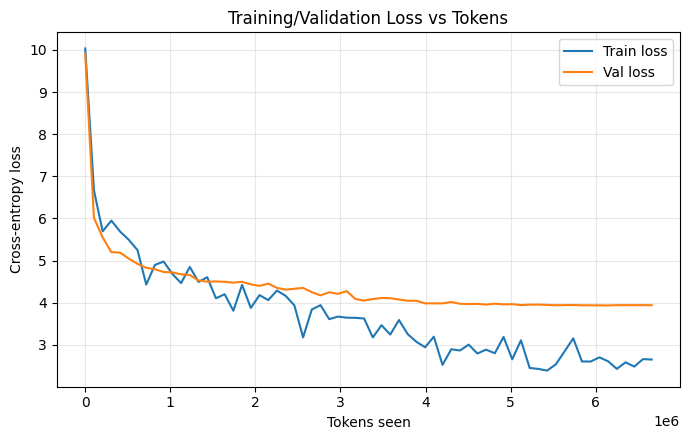

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(tokens_seen, train_losses, val_losses, save_path=None):
    """
    tokens_seen: list from train_model_simple (logged at each eval)
    train_losses, val_losses: same length as tokens_seen
    """
    if not (len(tokens_seen) == len(train_losses) == len(val_losses)):
        raise ValueError("tokens_seen, train_losses, val_losses must have same length")

    plt.figure(figsize=(7,4.5))
    plt.plot(tokens_seen, train_losses, label="Train loss")
    plt.plot(tokens_seen, val_losses, label="Val loss")
    plt.xlabel("Tokens seen")
    plt.ylabel("Cross-entropy loss")
    plt.title("Training/Validation Loss vs Tokens")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

plot_losses(tokens_seen, train_losses, val_losses, save_path="loss_plot.png")

# Loading trained model later